In [1]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from ntask.atrs import AtrModel, AtrMovingAverage
from ntask.callbacks import AtrLogger
from ntask.layers import Context
from ntask.models import NTaskModel
from ntask.flags import Verbosity
from ntask.utils import set_seed

In [2]:
class AtrSMA(AtrMovingAverage):
    def __init__(self, num_periods, switch_threshold_scale, switch_threshold_offset, add_threshold=0.0, max_contexts=0):
        super(AtrSMA, self).__init__(switch_threshold_offset, add_threshold, max_contexts)
        self.dyn_switch_threshold = switch_threshold_offset
        self.switch_threshold_scale = switch_threshold_scale
        self.periods = num_periods
        
    
    def build(self, num_contexts):
        super(AtrSMA, self).build(num_contexts)
        self.sma_updates = tf.Variable(np.zeros(self.num_contexts), name="SMA_Update_Count", trainable=False, dtype=tf.int64)
        self.sma_values = tf.Variable(np.zeros((self.num_contexts, self.periods)), name="SMA_Period_Values", trainable=False, dtype=tf.float64)
    
    
    def context_loss_fn(self, context_delta):
        return tf.keras.losses.mean_squared_error(np.zeros(len(context_delta)), context_delta)
    
    
    def update_atr_value(self, context_loss, switched):
        if switched or not self.values_initialized[self.hot_context]:
            self.sma_values.scatter_nd_update([[self.hot_context]], [np.zeros(self.periods)])
            self.sma_updates.scatter_nd_update([[self.hot_context]], [0])
        
        # Update the SMA values and update counter
        self.sma_values.scatter_nd_update([[self.hot_context, self.sma_updates[self.hot_context] % self.periods]], [context_loss])
        self.sma_updates.scatter_nd_add([[self.hot_context]], [1])
        
        # Calculate the mean and standard deviation
        mean = tf.math.reduce_mean(self.sma_values[self.hot_context][:self.sma_updates[self.hot_context]])
        std = tf.math.reduce_std(self.sma_values[self.hot_context])
            
        # Update the ATR and STD values
        self.set_atr_value(mean)
        self.switch_threshold.assign(self.switch_threshold_scale*tf.cast(-std, tf.float32) + self.dyn_switch_threshold)
            
#     def should_switch(self, epoch, context_loss):
#         return False
            
#     def should_add_context(self, context_loss, best_fit_context_idx):
#         return False

## Utility Functions

In [3]:
def one_hot_encode(value, n_values):
    x = np.zeros(n_values)
    x[value] = 1
    return x

In [4]:
def skip_randint(max_value, skip):
    """
    Generate a new random integer between 0 and `max_value`.
    The returned value will not equal `skip`
    """
    value = np.random.randint(max_value - 1)
    return value if value < skip else (value + 1)

In [5]:
def plot(model, maze_size):
    action_values = model.predict(np.identity(maze_size)).T
    fig, ax = plt.subplots()
    x = np.arange(maze_size + 1)
    for i, label in enumerate(("left", "right")):
        values = action_values[i]
        ax.plot(x, np.concatenate((values, values[:1])), label=label)
    ax.grid()
    ax.legend()

## Q-learning

In [6]:
def policy(model, state, epsilon):
    """
    Epsilon-greedy policy selection
    """
    values = model.predict(state.reshape((1,) + state.shape))[0]
    if np.random.random() < epsilon:
        return np.random.randint(len(values))
    else:
        return np.argmax(values)

In [206]:
def reward(state, goal):
    if state == goal:
        return 1.0
    return -1.0

In [207]:
def update(model, prev_state, state, action, reward, alpha, gamma, absorb=False, **kwargs):
    """
    Perform a Q-learning update
    """
    # Reshape the `prev_state` and `state` inputs
    prev_state = prev_state.reshape((1,) + prev_state.shape)
    state = state.reshape((1,) + state.shape)
    
    # Grab the previous state values
    target = model.predict(prev_state)
    
    # Adjust the target
    q_old = target[0][action]
    if absorb:
        target[0][action] = q_old + alpha*(reward - q_old)
    else:
        q_max = np.max(model.predict(state))
        target[0][action] = q_old + alpha*(reward + gamma*q_max - q_old)
        
    # Fit the model
    model.fit(prev_state, target, verbose=Verbosity.Contexts, train_after_switch=False, find_best_fit=False, **kwargs)

In [208]:
def episode(model, goal, maze_size, limit, alpha, gamma, epsilon, verbosity=0, start_state=None, **kwargs):
    states_enc = np.identity(maze_size) # state one-hot encodings
    state = start_state if start_state is not None else skip_randint(maze_size, goal)
    moves = 0
    while state != goal and moves < limit:
        
        # Make the prediction at the current state
        action = policy(model, states_enc[state], epsilon)
        
        if verbosity:
            print(f"{state}: {'right' if action else 'left'}")
        
        # Move to the next state and store the previous action
        prev_state, state = state, (state + (-1 if action == 0 else 1)) % maze_size
        
        # Calculate the reward and update the model
        r = reward(state, goal)
        update(model, states_enc[prev_state], states_enc[state], action, r, alpha, gamma, absorb=(state == goal), **kwargs)
        
        # Count the moves
        moves += 1
    
    return state == goal, moves

In [209]:
def train(model, maze_size, goals, limit, episodes, alpha, gamma, epsilon, switch_freq=100, initial_shuffle=False, shuffle=False, **kwargs):
    goal_indices = np.arange(len(goals))
    goal = -1
    num_finished = 0
    for ep in range(episodes):
#         if num_finished >= switch_freq or ep == 0:
        if ep % switch_freq == 0:
            num_finished = 0
            goal = (goal + 1) % len(goals)
            print("Switched to goal:", goals[goal_indices[goal]], "at epoch", ep+1)
            if shuffle or ep == 0 and initial_shuffle:
                np.random.shuffle(goal_indices)
            
        print(f"{ep+1}/{episodes}", end="\r")
        result = episode(model, goals[goal_indices[goal]], maze_size, limit, alpha, gamma, epsilon, **kwargs)
        if result[0]:
            num_finished += 1

___

## 1D Maze

In [224]:
set_seed(1)

### Maze Settings

In [225]:
# Maze Settings
maze_size = 10
goals = (0, 5)

### Model Architecture

In [226]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(1e-3)

# Hyperparameters
maze_size = 10
hrr_size = 1024
num_contexts = len(goals)
switch_threshold = -0.008

# Model Architecture
inp = Input((maze_size,))
x = Flatten()(inp)
x = Dense(hrr_size, activation="relu", use_bias=False)(x)
x = Context(num_contexts, AtrMovingAverage(switch_threshold))(x)
x = Dense(2, activation="linear", use_bias=False)(x)

# Create the model
model = NTaskModel(inputs=inp, outputs=x)

# Compile the model
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)

### Training

In [227]:
learn_rate = 1.0
discount_factor = 0.5
epsilon = 0.1

move_limit = 30

# episodes = 300

logger = AtrLogger(track_epochs_internally=True)
callbacks = [logger]

In [228]:
train(model, maze_size, goals, move_limit, 100, learn_rate, discount_factor, epsilon, switch_freq=100, callbacks=callbacks)

Switched to goal: 0 at epoch 1


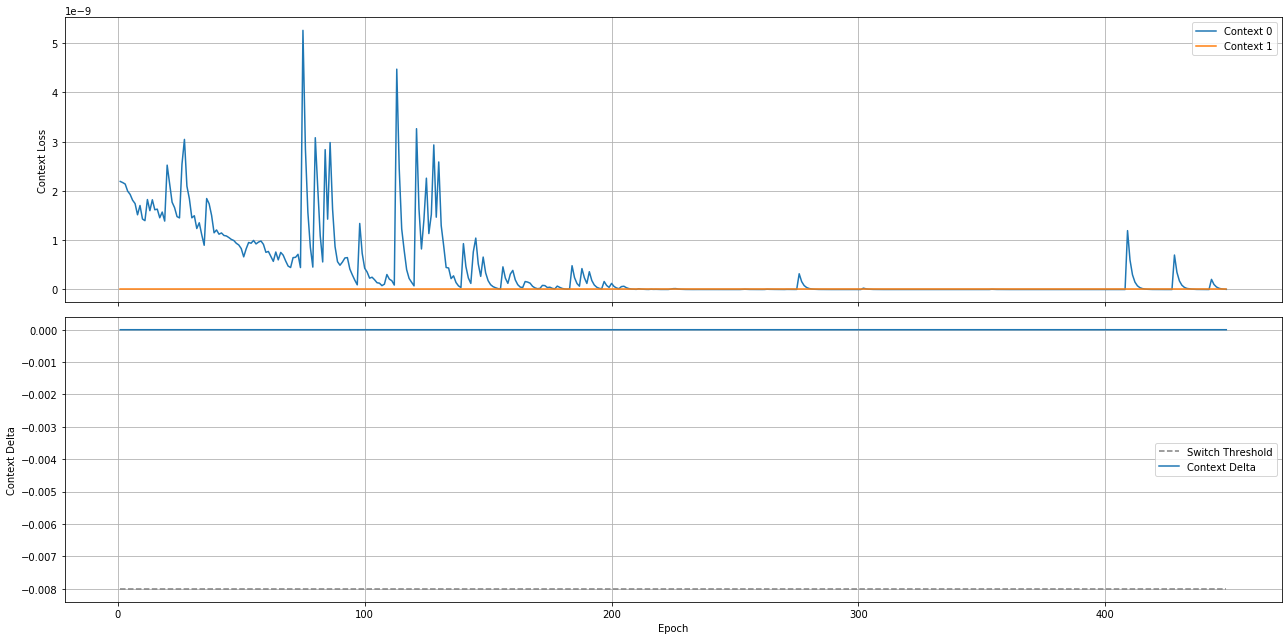

In [229]:
logger.plot(figsize=(18,9))

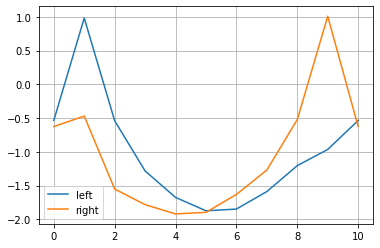

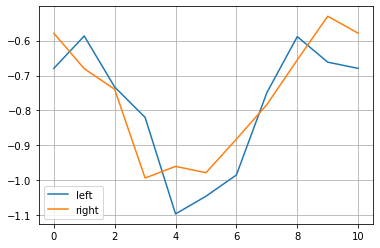

In [230]:
for ctx in range(len(goals)):
    model.set_contexts([ctx])
    plot(model, maze_size)

In [156]:
weights = tf.python.keras.backend.batch_get_value(model.trainable_weights)

In [ ]:
episode(model, 5, maze_size, move_limit, learn_rate, discount_factor, 0, verbosity=1, start_state=9, callbacks=callbacks)

In [270]:
tf.python.keras.backend.batch_set_value(zip(model.trainable_weights, weights))

In [273]:
model.set_contexts([0])

In [196]:
values, action = policy(model, one_hot_encode(9, 10), 0)

In [197]:
values

array([-1.881176 ,  0.0234618], dtype=float32)

In [198]:
update(model, one_hot_encode(9, 10), one_hot_encode(0, 10), values, action, -1, learn_rate, discount_factor, absorb=False)


[context_6] Switched context to 1


In [209]:
tf.equal(model.trainable_weights[0], weights[0]).numpy().all()

True

In [203]:
tf.equal

<function tensorflow.python.ops.math_ops.equal(x, y, name=None)>